In [1]:
import numpy as np
from scipy import optimize
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
import pandas as pd
import helpers
import scipy
import itertools
import glob

In [2]:
without_coma_ids_to_idx = {'5037': 3, '4141': 3}

def process_line(line): 
    line = line.strip()
    line = [token for token in line.split(' ') if token]
    id_ = line[0]
    if id_ in without_coma_ids_to_idx:
        name_last_idx = without_coma_ids_to_idx[id_]
    else:
        name_last_idx = [i for i, token in enumerate(line) if ',' in token][0]
    name = ' '.join(line[1:name_last_idx+1])[:-1]
    code = line[name_last_idx+1]
    city = ' '.join(line[name_last_idx+2:])
    return id_, name, code, city

def return_stops(filename): 
    with open(filename, 'r') as file: 
        lines = file.readlines()
    indices = [i for i, line in enumerate(lines) if '*ZA' in line or '#ZA' in line]
    lines = lines[min(indices)+1: max(indices)]
    stops = []
    for line in lines:
        stops.append(process_line(line))
    
    return pd.DataFrame(stops, columns=['id', 'name','code', 'city'])
stops = pd.concat([return_stops(file) for file in glob.glob('ZTM/*.TXT')]).drop_duplicates()
stops = stops.loc[~((stops['id'] == '2423') & (stops['name'] == 'Ruty'))]

In [3]:
stops.to_csv('spots.csv', index=False)

In [4]:
def parse(filename = 'RA221205.TXT'):
    """
    Author: Dawid Przybyliński
    """
    with open(filename, 'r') as file:
        Lines = file.readlines()

        stops = []
        conns = []
        for i in range(len(Lines)):
            line = Lines[i]
            if "*PR" in line:        
                # id and name from previous line
                line_split = Lines[i-1].split(" ")
                non_empty_line_split = np.array(list(filter(None, line_split)))
                stop_id = non_empty_line_split[0]
                stop_name = ' '.join(non_empty_line_split[1:-2])
                if stop_name[-1] == ',':
                    stop_name = stop_name[:-1]


                # coordinates from previous line
                line_split = Lines[i+1].split(" ")
                non_empty_line_split = np.array(list(filter(None, line_split)))
                Y = non_empty_line_split[np.where(non_empty_line_split == 'Y=')[0][0]+1]
                X = non_empty_line_split[np.where(non_empty_line_split == 'X=')[0][0]+1]

                # append stop info
                stops.append([int(stop_id), stop_name, float(Y), float(X)])

            # get connection type
            if "*TR" in line:
                line_split = Lines[i-1].split(" ")
                non_empty_line_split = np.array(list(filter(None, line_split)))
                type_name_pl = ' '.join(non_empty_line_split[np.where(non_empty_line_split == "-")[0][0] + 1:])
                if type_name_pl[-1:] == "\n":
                    type_name_pl = type_name_pl[:-1]

            # get connections from a route
            if "*LW" in line:
                # chain of stops in a route
                stop_chain = []
                j = 0
                while "#LW" not in Lines[i+j]:
                    line_split = Lines[i+j].split(" ")
                    non_empty_line_split = np.array(list(filter(None, line_split)))
                    stop_id_place = np.where(np.array([len(x)==6 and np.char.isnumeric(x) for x in non_empty_line_split]))
                    if len(stop_id_place[0]) != 0:
                        stop_chain.append(int(non_empty_line_split[stop_id_place[0][0]][0:4]))
                    j += 1

                # convert chain to connections
                for i in range(len(stop_chain)-1):
                    if stop_chain[i] != stop_chain[i+1]:
                        if stop_chain[i] == 4040:
                            stop_chain[i] = 4021
                        if stop_chain[i] == 1484:
                            stop_chain[i] = 1483
                        if stop_chain[i+1] == 4040:
                            stop_chain[i+1] = 4021
                        if stop_chain[i+1] == 1484:
                            stop_chain[i+1] = 1483
                        conns.append([stop_chain[i], stop_chain[i+1], type_name_pl])

        stops_df = pd.DataFrame(stops, columns=["ZTM_ID", "name", "lat", "long"]).reset_index(drop=True)
        conns_df = pd.DataFrame(conns, columns=["from", "to", "type_name_pl"])

        # Those stops appear in connections but not stops and are changed to the only stop they are connected to:
        # Lotnisko Chopina: 4040 -> 4201;
        # Dom Samotnej Matki: 1484 -> 1483 (Chlubna)
        return stops_df, conns_df
stops_df, conns_df = parse(glob.glob('ZTM/*.TXT')[0])

### P8.1

In [5]:
def plot_C_k(G, ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    c_coefs = np.array(list(nx.algorithms.cluster.clustering(G).values()))
    degrees = np.array(list(dict(G.degree()).values())) 
    unique_degrees = sorted(set(degrees))
    coefs_to_plot = []
    for degree in unique_degrees: 
        coefs_to_plot.append(c_coefs[degrees == degree].mean())
    ax.scatter(unique_degrees, coefs_to_plot)
    ax.plot(unique_degrees, 1/np.array(unique_degrees), linestyle='--', color='red', label='1/k')
    ax.set_xlabel('Degree')
    ax.set_ylabel('C(k)')
    ax.legend()


### P8.2

In [6]:
def get_got_graph(file='got8.csv', character='TYRION', figsize=None):
    csv_data = open(file, "r")
    next(csv_data, None) 
    G = nx.parse_edgelist(csv_data, delimiter=',', create_using=nx.Graph(),
                          nodetype=str, data=(('weight', float),))

    return G

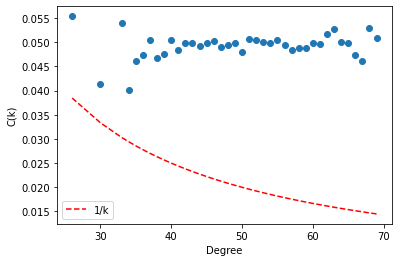

In [7]:
plot_C_k(nx.erdos_renyi_graph(1000, 0.05))

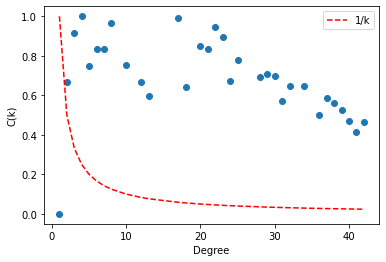

In [8]:
plot_C_k(get_got_graph())

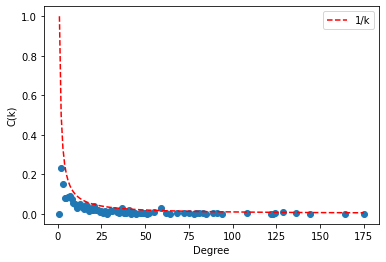

In [9]:
plot_C_k(nx.read_edgelist('web-EPA.edges'))

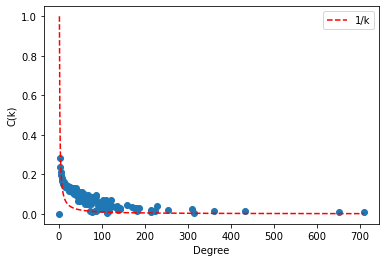

In [10]:
plot_C_k(nx.read_edgelist('cit-DBLP.edges'))

In [11]:
def return_graph_from_stops_and_conns(stops_df, conns_df, transport_type=None):
    G = nx.Graph()
    
    
    if transport_type is not None: 
        conns_df = conns_df.loc[conns_df['type_name_pl'] == transport_type]

        stops_df = (stops_df[['ZTM_ID']].merge(conns_df[['from']], right_on='from', left_on='ZTM_ID')
            .merge(conns_df[['to']], right_on='to', left_on='ZTM_ID'))

    for ztm_id in set(stops_df['ZTM_ID']):
        G.add_node(ztm_id)
    
    for (u, v) in conns_df[['from', 'to']].apply(tuple, axis=1):
        G.add_edge(u, v)
        
    return G
G = return_graph_from_stops_and_conns(stops_df, conns_df)

### P8.3

In [12]:
graphs = {}
all_transport_types = set(conns_df['type_name_pl'])
for transport_type in all_transport_types:
    graphs[transport_type] = return_graph_from_stops_and_conns(stops_df, conns_df, transport_type=transport_type)
    
graphs['All transports'] = return_graph_from_stops_and_conns(stops_df, conns_df)

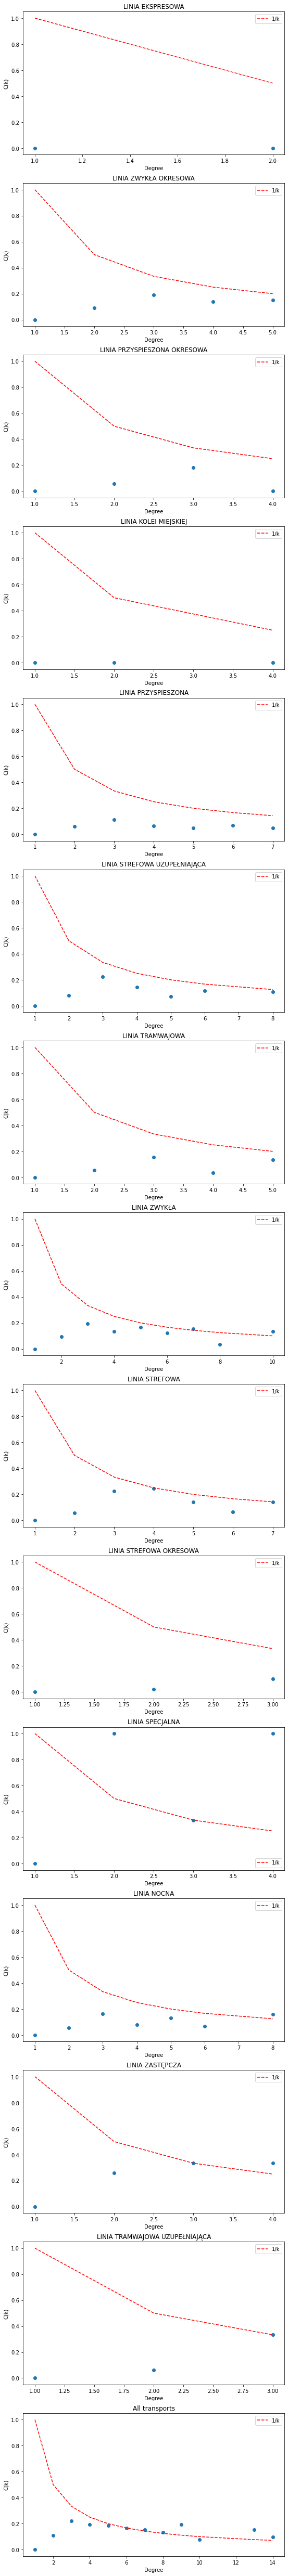

In [13]:
fig, axs = plt.subplots(nrows=len(graphs) , figsize=(9, 6*len(graphs) ))
for i, (transport_type, graph) in enumerate(graphs.items()):
    plot_C_k(graph, ax=axs[i])
    axs[i].set_title(transport_type)
    

### P8.5

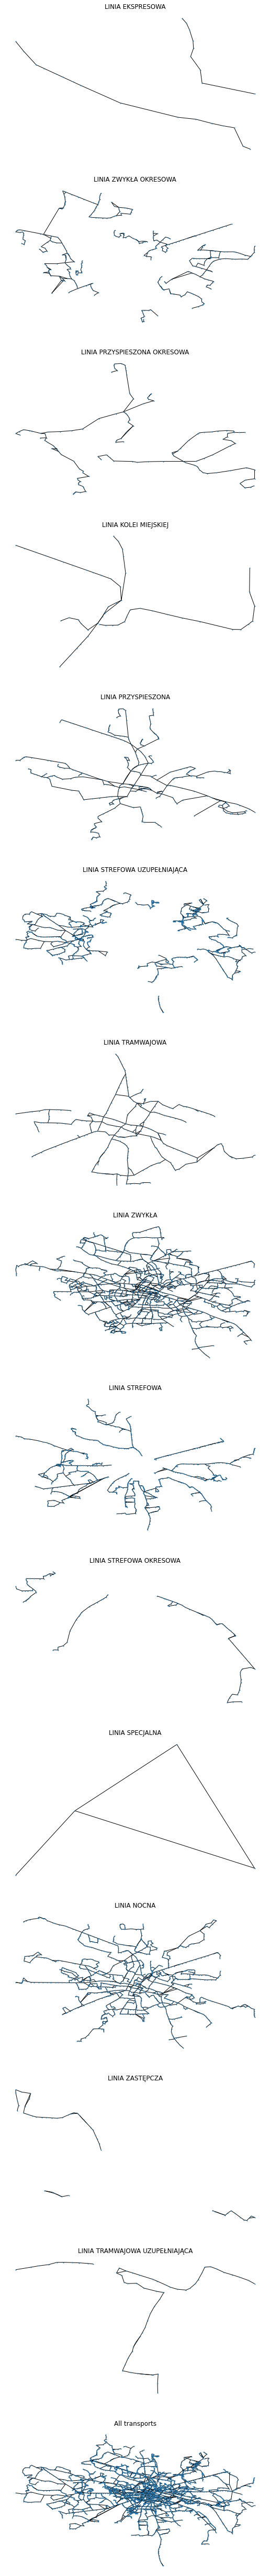

In [14]:
fig, axs = plt.subplots(nrows=len(graphs) , figsize=(9, 6*len(graphs) ))
for i, (transport_type, graph) in enumerate(graphs.items()):
    nx.draw(graph, 
            node_size=1, pos=dict(zip(stops_df['ZTM_ID'], tuple(zip(stops_df['lat'], stops_df['long'])))), ax=axs[i])
    axs[i].set_title(transport_type)
    

### P8.4 

In [15]:
from helpers import MLE_alpha
def return_stats(G, transport_type):
    stats = {}
    degrees = np.array(list(dict(G.degree).values()))
    stats['transport_type'] = [transport_type]
    stats['is_directed'] = [G.is_directed()]
    stats['N'] = [G.number_of_nodes()]
    stats['E'] = [G.number_of_edges()]
    stats['<k>'] = [degrees.mean()]
    stats['alpha'] = [MLE_alpha(degrees)]
    stats['r'] = [nx.algorithms.assortativity.degree_pearson_correlation_coefficient(G)]
    return pd.DataFrame(stats).reset_index(drop=True)
pd.concat([return_stats(G, transport_type) for transport_type, G in graphs.items()])

,transport_type,is_directed,N,E,<k>,alpha,r
0,LINIA EKSPRESOWA,False,25,23,1.840000,2.717494,-0.095238
0,LINIA ZWYKŁA OKRESOWA,False,338,370,2.189349,2.335749,0.043713
0,LINIA PRZYSPIESZONA OKRESOWA,False,124,127,2.048387,2.437656,-0.010713
0,LINIA KOLEI MIEJSKIEJ,False,53,52,1.962264,2.560466,-0.025961
0,LINIA PRZYSPIESZONA,False,305,338,2.216393,2.335449,0.062870
0,LINIA STREFOWA UZUPEŁNIAJĄCA,False,918,1077,2.346405,2.238314,0.169408
0,LINIA TRAMWAJOWA,False,235,261,2.221277,2.325492,0.061042
0,LINIA ZWYKŁA,False,1471,1945,2.644460,2.104142,0.183213
0,LINIA STREFOWA,False,748,836,2.235294,2.304594,0.196275
0,LINIA STREFOWA OKRESOWA,False,111,114,2.054054,2.434881,-0.060017


### P8.9

In [16]:
pkin_coords = (52.23156086855663, 21.00615590526811)

In [17]:
import geopy.distance
stops_df['distance_from_center'] = stops_df[['lat', 'long']].apply(tuple, axis=1)\
    .apply(lambda x: geopy.distance.geodesic(pkin_coords, x).km)\
    .apply(lambda x: round(x, 2))

In [18]:
center_stop_id = stops_df[stops_df['name'] == 'Centrum']['ZTM_ID'].iloc[0]
center_stop_id

7013

In [19]:
distances = {}
for u, v in graphs['All transports'].edges():
    u_cords = stops_df[stops_df['ZTM_ID'] == u][['lat','long']].apply(tuple, axis=1).iloc[0]
    v_cords = stops_df[stops_df['ZTM_ID'] == v][['lat','long']].apply(tuple, axis=1).iloc[0]
    distances[(u, v)] = geopy.distance.geodesic(u_cords, v_cords).km

In [20]:
nx.set_edge_attributes(graphs['All transports'], distances, name='weight')

In [21]:
shortest_path_length = {}
for node in graphs['All transports'].nodes(): 
    try:
        shortest_path_length[node] = len(nx.shortest_path(graphs['All transports'], node, center_stop_id))
    except nx.NetworkXNoPath: 
        shortest_path_length[node] = 9999

In [22]:
stops_df['shortest_path_length'] = stops_df['ZTM_ID'].map(shortest_path_length)

In [23]:
distances_from_center = stops_df.merge(conns_df, left_on='ZTM_ID', right_on='from', how='left')\
    .groupby(['ZTM_ID', 'distance_from_center', 'name', 'shortest_path_length'])\
    .count().reset_index().rename({'lat': 'number_of_connections'}, axis=1)\
    [['ZTM_ID', 'name', 'number_of_connections', 'distance_from_center', 'shortest_path_length']]

In [24]:
distances_from_center.sort_values(['number_of_connections', 'distance_from_center'], ascending=[True, False]).head(5)

,ZTM_ID,name,number_of_connections,distance_from_center,shortest_path_length
2733,6817,Kampinos,1,37.34,50
2734,6818,Niepokalanowska,1,37.24,50
1886,3954,Pieczyska,1,34.47,45
1878,3894,Urząd Gminy,1,32.56,45
1877,3893,Czołchańskiego,1,32.50,46


In [25]:
distances_from_center.sort_values(['number_of_connections', 'distance_from_center'], ascending=[True, False]).tail(5)

,ZTM_ID,name,number_of_connections,distance_from_center,shortest_path_length
0,1001,Kijowska,58,3.24,5
2755,7014,Metro Świętokrzyska,73,0.54,2
2,1003,Dw.Wileński,76,3.18,6
2754,7013,Centrum,96,0.48,1
2744,7002,Dw.Centralny,101,0.44,2


In [26]:
distances_from_center.sort_values(['shortest_path_length', 'distance_from_center'], ascending=[False, False]).tail(5)

,ZTM_ID,name,number_of_connections,distance_from_center,shortest_path_length
2753,7012,Hoża,20,0.86,2
2773,7033,Krucza,50,0.81,2
2755,7014,Metro Świętokrzyska,73,0.54,2
2744,7002,Dw.Centralny,101,0.44,2
2754,7013,Centrum,96,0.48,1


In [27]:
distances_from_center[distances_from_center['shortest_path_length'] != 9999]\
    .sort_values(['shortest_path_length', 'distance_from_center'], ascending=[False, False]).head(5)

,ZTM_ID,name,number_of_connections,distance_from_center,shortest_path_length
2717,6680,"Cybulice Duże, CY",1,30.25,55
2716,6679,"Sowia Wola Folwarczna, SĄ SOWIA",2,29.69,54
2715,6678,"Stokrotki, S6",2,29.46,53
2714,6677,"Spacerowa, S6",2,29.04,52
402,1444,"Nowe Załubice, ZN",1,29.25,51
